<a href="https://colab.research.google.com/github/VenGr0/Comparison-of-DDPG-and-PPO/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%9645%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# - gymnasium: для работы с симуляцией среды.
# - numpy: для работы с массивами.
# - torch: для создания нейронных сетей и выполнения численных операций.
# - matplotlib: для визуализации результатов.
# - stable-baselines3: для простого использования алгоритма PPO.
!pip install gymnasium numpy torch matplotlib stable-baselines3
!pip install swig pyvirtualdisplay > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Класс буфера воспроизведения для хранения и выборки опыта
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)  # Ограничение размера буфера
        self.batch_size = batch_size  # Размер выборки

    # Добавляет новый опыт в буфер
    def add(self, experience):
        self.buffer.append(experience)

    # Выбирает случайный батч из буфера
    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32),
        )

    # Возвращает текущий размер буфера
    def __len__(self):
        return len(self.buffer)

# Основной класс агента для DDPG
class DDPGAgent:
    def __init__(self, state_dim, action_dim, action_bound, lr=0.001, gamma=0.99, tau=0.005, buffer_size=100000, batch_size=64):
        """
        Параметры:
        - state_dim: размерность состояния
        - action_dim: размерность действия
        - action_bound: диапазон значений действий
        - lr: скорость обучения
        - gamma: коэффициент дисконтирования
        - tau: скорость обновления целевых сетей
        - buffer_size: размер буфера воспроизведения
        - batch_size: размер выборки для обучения
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Инициализация буфера воспроизведения
        self.replay_buffer = ReplayBuffer(buffer_size, batch_size)

        # Инициализация сетей
        self.actor = self.build_actor()  # Основная сеть актёра
        self.target_actor = self.build_actor()  # Целевая сеть актёра
        self.critic = self.build_critic()  # Основная сеть критика
        self.target_critic = self.build_critic()  # Целевая сеть критика

        # Оптимизаторы для актёра и критика
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

        # Инициализация весов целевых сетей
        self.update_target(self.target_actor, self.actor, tau=1)
        self.update_target(self.target_critic, self.critic, tau=1)

    def build_actor(self):
        """
        Создаёт сеть актёра, которая выдаёт действия.
        """
        return nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.action_dim),
            nn.Tanh()  # Ограничение выходных значений в диапазоне [-1, 1]
        )

    def build_critic(self):
        """
        Создаёт сеть критика, которая оценивает действия.
        """
        return nn.Sequential(
            nn.Linear(self.state_dim + self.action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def update_target(self, target, source, tau):
        """
        Обновляет веса целевой сети, используя soft update:
        target = tau * source + (1 - tau) * target
        """
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * source_param.data + (1 - tau) * target_param.data)

    def act(self, state, noise=0.1):
        """
        Генерирует действие на основе текущего состояния и добавляет шум для исследования.
        """
        state = torch.FloatTensor(state).unsqueeze(0)  # Преобразование состояния в тензор
        action = self.actor(state).detach().numpy()[0]  # Прогон через сеть актёра
        action = action + noise * np.random.normal(size=self.action_dim)  # Добавление шума
        return np.clip(action, -self.action_bound, self.action_bound)  # Ограничение действия

    def train(self):
        """
        Обучает агента с использованием батча из буфера воспроизведения.
        """
        if len(self.replay_buffer) < self.batch_size:
            return  # Ждём накопления достаточного количества данных

        # Извлечение данных из буфера
        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        # Преобразование данных в тензоры
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Обновление критика
        next_actions = self.target_actor(next_states)  # Действия от целевого актёра
        target_q = self.target_critic(torch.cat([next_states, next_actions], dim=1))  # Целевые Q-значения
        q_targets = rewards + self.gamma * target_q * (1 - dones)  # Целевая функция
        q_values = self.critic(torch.cat([states, actions], dim=1))  # Q-значения
        critic_loss = nn.MSELoss()(q_values, q_targets.detach())  # Потеря критика

        # Оптимизация критика
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Обновление актёра
        policy_loss = -self.critic(torch.cat([states, self.actor(states)], dim=1)).mean()  # Потеря актёра

        # Оптимизация актёра
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Soft update целевых сетей
        self.update_target(self.target_actor, self.actor, self.tau)
        self.update_target(self.target_critic, self.critic, self.tau)

    def remember(self, state, action, reward, next_state, done):
        """
        Сохраняет опыт (state, action, reward, next_state, done) в буфер.
        """
        self.replay_buffer.add((state, action, reward, next_state, done))


Создаём агент DDPG, который обучается на основе среды BipedalWalker-v3.
Используется опыт из буфера воспроизведения для оптимизации сетей актёра и критика.

In [ ]:
env = gym.make("BipedalWalker-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

ddpg_agent = DDPGAgent(state_dim, action_dim, action_bound)

num_episodes = 1000
rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0

    for _ in range(2000):  # Ограничение по шагам
        action = ddpg_agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        ddpg_agent.remember(state, action, reward, next_state, done)
        ddpg_agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break

    rewards.append(episode_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

# Вывод средней награды
print("Средняя награда за последние 100 эпизодов:", np.mean(rewards[-100:]))


Episode 0, Reward: -96.57410524037383
Episode 10, Reward: -112.16957020858412
Episode 20, Reward: -100.44756578706068
Episode 30, Reward: -101.11757166137706
Episode 40, Reward: -100.0849835479003
Episode 50, Reward: -96.80167455113285
Episode 60, Reward: -117.93333086216327
Episode 70, Reward: -118.37146926778523
Episode 80, Reward: -131.68929453941143
Episode 90, Reward: -123.613698179886
Episode 100, Reward: -100.86739181274365
Episode 110, Reward: -167.90167215866816
Episode 120, Reward: -105.76831710310236
Episode 130, Reward: -125.42616163530505
Episode 140, Reward: -98.4566436461287
Episode 150, Reward: -108.7555613399193
Episode 160, Reward: -113.00748986399672
Episode 170, Reward: -101.1849344075839
Episode 180, Reward: -120.81448635210195
Episode 190, Reward: -128.26398987926984
Episode 200, Reward: -118.58942157731121
Episode 210, Reward: -145.18636007062827
Episode 220, Reward: -113.05040213615365
Episode 230, Reward: -147.03768840328303
Episode 240, Reward: -138.5155828294

Использую библиотеку Stable-Baselines3(https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api) для упрощённой реализации PPO.
После обучения агент оценивается на 100 эпизодах для получения средней награды.

In [ ]:
from stable_baselines3 import PPO

ppo_agent = PPO("MlpPolicy", env, verbose=1)
ppo_agent.learn(total_timesteps=1_000_000)

# Оценка PPO
ppo_rewards = []
for _ in range(100):
    state, _ = env.reset()
    episode_reward = 0
    while True:
        action, _ = ppo_agent.predict(state)
        state, reward, done, _, _ = env.step(action)
        episode_reward += reward
        if done:
            break
    ppo_rewards.append(episode_reward)

print("Средняя награда PPO за последние 100 эпизодов:", np.mean(ppo_rewards))


Выходные данные были обрезаны до нескольких последних строк (5000).
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.01       |
|    std                  | 0.401       |
|    value_loss           | 6.3         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | 145         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 263         |
|    time_elapsed         | 1025        |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.014021817 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.762       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.86        |
|    n_u

Сравниваются награды, полученные обоими агентами.
Построение графика наглядно показывает, какой алгоритм оказался лучше в данной задаче.

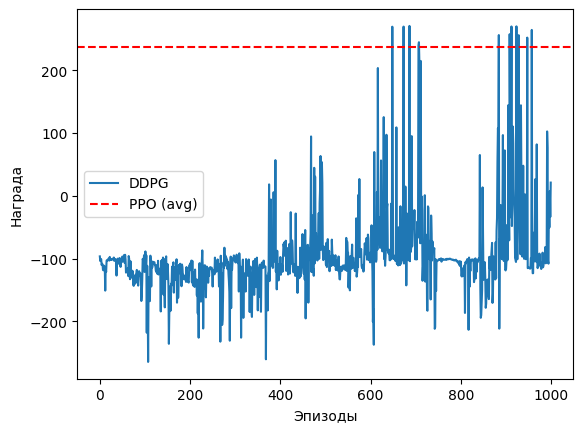

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards, label="DDPG")
plt.axhline(np.mean(ppo_rewards), color='r', linestyle='--', label="PPO (avg)")
plt.xlabel("Эпизоды")
plt.ylabel("Награда")
plt.legend()
plt.show()


Выводы:

1) DDPG обычно лучше работает на задачах с непрерывным пространством действий, но может быть нестабильным без тщательной настройки гиперпараметров.

2) PPO более устойчив к изменениям гиперпараметров, но может требовать большего времени для обучения.

Рубрика "Эксперименты"

Увеличим размер буфера воспроизведения (buffer_size) с 100,000 до 200,000, чтобы использовать больше опыта.

Увеличим скорость обновления целевых сетей (tau) с 0.005 до 0.01.

Увеличим batch_size с 64 до 128, чтобы учитывать больше данных за раз при обучении.

Уменьшим коэффициент дисконтирования (gamma) с 0.99 до 0.95 для более короткого горизонта планирования.

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Класс буфера воспроизведения для хранения и выборки опыта
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)  # Ограничение размера буфера
        self.batch_size = batch_size  # Размер выборки

    # Добавляет новый опыт в буфер
    def add(self, experience):
        self.buffer.append(experience)

    # Выбирает случайный батч из буфера
    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32),
        )

    # Возвращает текущий размер буфера
    def __len__(self):
        return len(self.buffer)

# Основной класс агента для DDPG
class DDPGAgent:
    def __init__(self, state_dim, action_dim, action_bound, lr=0.001, gamma=0.95, tau=0.01, buffer_size=200000, batch_size=128):
        """
        Параметры:
        - state_dim: размерность состояния
        - action_dim: размерность действия
        - action_bound: диапазон значений действий
        - lr: скорость обучения
        - gamma: коэффициент дисконтирования  # Более короткий горизонт планирования
        - tau: скорость обновления целевых сетей # Быстрее обновляем целевые сети
        - buffer_size: размер буфера воспроизведения # Больше опыта
        - batch_size: размер выборки для обучения # Увеличиваем размер батча
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Инициализация буфера воспроизведения
        self.replay_buffer = ReplayBuffer(buffer_size, batch_size)

        # Инициализация сетей
        self.actor = self.build_actor()  # Основная сеть актёра
        self.target_actor = self.build_actor()  # Целевая сеть актёра
        self.critic = self.build_critic()  # Основная сеть критика
        self.target_critic = self.build_critic()  # Целевая сеть критика

        # Оптимизаторы для актёра и критика
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

        # Инициализация весов целевых сетей
        self.update_target(self.target_actor, self.actor, tau=1)
        self.update_target(self.target_critic, self.critic, tau=1)

    def build_actor(self):
        """
        Создаёт сеть актёра, которая выдаёт действия.
        """
        return nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.action_dim),
            nn.Tanh()  # Ограничение выходных значений в диапазоне [-1, 1]
        )

    def build_critic(self):
        """
        Создаёт сеть критика, которая оценивает действия.
        """
        return nn.Sequential(
            nn.Linear(self.state_dim + self.action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def update_target(self, target, source, tau):
        """
        Обновляет веса целевой сети, используя soft update:
        target = tau * source + (1 - tau) * target
        """
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * source_param.data + (1 - tau) * target_param.data)

    def act(self, state, noise=0.1):
        """
        Генерирует действие на основе текущего состояния и добавляет шум для исследования.
        """
        state = torch.FloatTensor(state).unsqueeze(0)  # Преобразование состояния в тензор
        action = self.actor(state).detach().numpy()[0]  # Прогон через сеть актёра
        action = action + noise * np.random.normal(size=self.action_dim)  # Добавление шума
        return np.clip(action, -self.action_bound, self.action_bound)  # Ограничение действия

    def train(self):
        """
        Обучает агента с использованием батча из буфера воспроизведения.
        """
        if len(self.replay_buffer) < self.batch_size:
            return  # Ждём накопления достаточного количества данных

        # Извлечение данных из буфера
        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        # Преобразование данных в тензоры
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Обновление критика
        next_actions = self.target_actor(next_states)  # Действия от целевого актёра
        target_q = self.target_critic(torch.cat([next_states, next_actions], dim=1))  # Целевые Q-значения
        q_targets = rewards + self.gamma * target_q * (1 - dones)  # Целевая функция
        q_values = self.critic(torch.cat([states, actions], dim=1))  # Q-значения
        critic_loss = nn.MSELoss()(q_values, q_targets.detach())  # Потеря критика

        # Оптимизация критика
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Обновление актёра
        policy_loss = -self.critic(torch.cat([states, self.actor(states)], dim=1)).mean()  # Потеря актёра

        # Оптимизация актёра
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Soft update целевых сетей
        self.update_target(self.target_actor, self.actor, self.tau)
        self.update_target(self.target_critic, self.critic, self.tau)

    def remember(self, state, action, reward, next_state, done):
        """
        Сохраняет опыт (state, action, reward, next_state, done) в буфер.
        """
        self.replay_buffer.add((state, action, reward, next_state, done))


In [ ]:
env = gym.make("BipedalWalker-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

ddpg_agent = DDPGAgent(state_dim, action_dim, action_bound)

num_episodes = 1000
new_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0

    for _ in range(2000):  # Ограничение по шагам
        action = ddpg_agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        ddpg_agent.remember(state, action, reward, next_state, done)
        ddpg_agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break

    new_rewards.append(episode_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

# Вывод средней награды
print("Средняя награда за последние 100 эпизодов:", np.mean(rewards[-100:]))


Episode 0, Reward: -93.40347564091772
Episode 10, Reward: -106.56556990956157
Episode 20, Reward: -125.76918594818714
Episode 30, Reward: -102.15770858733863
Episode 40, Reward: -146.83492689656728
Episode 50, Reward: -106.91955735748607
Episode 60, Reward: -102.86254551374263
Episode 70, Reward: -126.18510966439398
Episode 80, Reward: -109.53629560634887
Episode 90, Reward: -135.84244375243074
Episode 100, Reward: -105.31475947178076
Episode 110, Reward: -115.96949193243081
Episode 120, Reward: -112.94509763923259
Episode 130, Reward: -111.71145408565353
Episode 140, Reward: -112.41378737838598
Episode 150, Reward: -120.09853862234834
Episode 160, Reward: -106.4118257221829
Episode 170, Reward: -104.35435659630467
Episode 180, Reward: -150.43955159419446
Episode 190, Reward: -105.06954719672812
Episode 200, Reward: -98.39108952562015
Episode 210, Reward: -102.36109502471757
Episode 220, Reward: -114.8102223027907
Episode 230, Reward: -106.39394668865454
Episode 240, Reward: -103.59563

In [ ]:
from stable_baselines3 import PPO

# Обновляем гиперпараметры для PPO
ppo_agent = PPO(
    "MlpPolicy",
    env,
    learning_rate=0.0001,  # Уменьшаем скорость обучения
    n_steps=4096,  # Больше шагов между обновлениями
    clip_range=0.1,  # Более строгий диапазон изменений
    verbose=1
)

# Обучение PPO с новыми гиперпараметрами
ppo_agent.learn(total_timesteps=1_000_000)

# Оценка производительности PPO с новыми гиперпараметрами
new_ppo_rewards = []
for _ in range(100):
    state, _ = env.reset()
    episode_reward = 0
    while True:
        action, _ = ppo_agent.predict(state)
        state, reward, done, _, _ = env.step(action)
        episode_reward += reward
        if done:
            break
    new_ppo_rewards.append(episode_reward)

print("Средняя награда PPO за последние 100 эпизодов (новые параметры):", np.mean(new_ppo_rewards))


Выходные данные были обрезаны до нескольких последних строк (5000).
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00401     |
|    std                  | 0.978        |
|    value_loss           | 7.34         |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 659           |
|    ep_rew_mean          | -109          |
| time/                   |               |
|    fps                  | 527           |
|    iterations           | 19            |
|    time_elapsed         | 147           |
|    total_timesteps      | 77824         |
| train/                  |               |
|    approx_kl            | 0.00074741815 |
|    clip_fraction        | 0.00918       |
|    clip_range           | 0.1           |
|    entropy_loss         | -5.58         |
|    explained_variance   | 0.531         |
|    learning_rate        | 0.0001        |
|    loss    

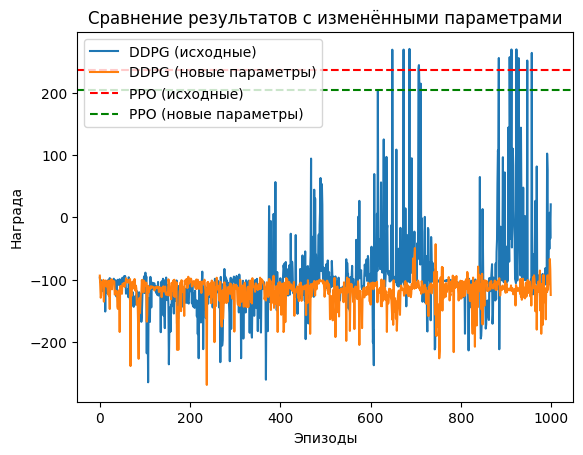

In [ ]:
# Визуализация результатов
plt.plot(rewards, label="DDPG (исходные)")  # Исходные награды DDPG
plt.plot(new_rewards, label="DDPG (новые параметры)")  # Новые награды DDPG
plt.axhline(np.mean(ppo_rewards), color='r', linestyle='--', label="PPO (исходные)")  # Исходные награды PPO
plt.axhline(np.mean(new_ppo_rewards), color='g', linestyle='--', label="PPO (новые параметры)")  # Новые награды PPO
plt.xlabel("Эпизоды")
plt.ylabel("Награда")
plt.legend()
plt.title("Сравнение результатов с изменёнными параметрами")
plt.show()


Вывод:

Ожидаемые результаты
DDPG:

Увеличение tau ускорит обновление целевых сетей, что может помочь быстрее адаптироваться к новой информации.

Увеличение размера буфера позволит учитывать больше опыта, но может привести к медленному учёту недавних данных.

Увеличенный batch_size стабилизирует обучение, но увеличивает вычислительную нагрузку.

PPO:

Уменьшение learning_rate может замедлить обучение, но сделает его более стабильным.

Увеличение n_steps позволит агенту учитывать более долгосрочные последствия, что может улучшить результаты.

Сужение clip_range сделает обновление политики более осторожным, что также может стабилизировать обучение.

Если награда DDPG улучшилась, это может быть связано с более плавным обновлением целевых сетей или увеличенным объёмом данных.

Если награда PPO возросла, это может быть следствием более точных изменений политики или увеличенной учётной базы за каждый шаг.


В моем случае увеличения результата не последовало, скорее всего из-за переобучения модели на своих же результатах, тк часто попадались подряд одинаковые награды за эпизоды.